# NMF analysis on calcium movies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import os

from patchnmf.analyse.nmf import cv_nmf
from patchnmf.analyse.compute import downsample_tiff_avg, compute_nmfpx_blur_thr, get_loading_times
from patchnmf.simulate import poiss_train, make_sim_path, run_simulation, reshape_list_im_to_mat, plot_covmat, covariance_sort 
from patchnmf.plot import plot_nmfpx_blur_thr, plot_roi_loading_time, plot_roi_loading_time, plot_compare_px_truth_nmf, plot_cv_opt, plot_compare_t_truth_nmf, animate_movie

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Setting parameters

In [2]:
rand_seed = 13121312 # randomisation seed (for clustering -> be careful to chose seed that generates non-spatially overlapping patches!!!
permute = False # when generating a movie gif -> do you want to keep spatial structure of patches ('development') or you want to shuffle pixels ('hippo assemblies')

In [3]:
n_clusters = 4

In [4]:
# setting simulation params
class SimParams:
    def __init__(self):
        
        self.sim_id = 'sim03'
        
        self.xy_px = 32
        self.t_max = 2048
        self.patch_size_max = 6
        self.patch_size_min = 4
        self.poiss_tau = 50
        self.act_tau = 4
        self.kernel_range = 256
        self.im_noise = 1
        self.smoothing_sigma = 0.5
        self.n_patches = 3
        self.act_scaling = 3

params = SimParams()

In [5]:
# setting analysis/NMF params
# setting nmf params
n_components = params.n_patches + 5 # plot 5 additional components
blur_std = 1 # blur to get pxNMF smoothed/binary masks (like in real data)

In [6]:
# setting cv nmf params
replicates = 1 # can be run multiple times for robustness
r_max = n_components
step = 1 # increase step for long simulations

## Start of script

In [7]:
# this will be where all the simulation data and outputs are stored under the 'data' folder
sim_path = make_sim_path(params.sim_id)

In [8]:
# this simulates the movie and gives the true patches and how they are activated over time. It also gives a movie by adding all of these and some noise
truth_pxs, truth_ts, movie = run_simulation(params, rand_seed=rand_seed)

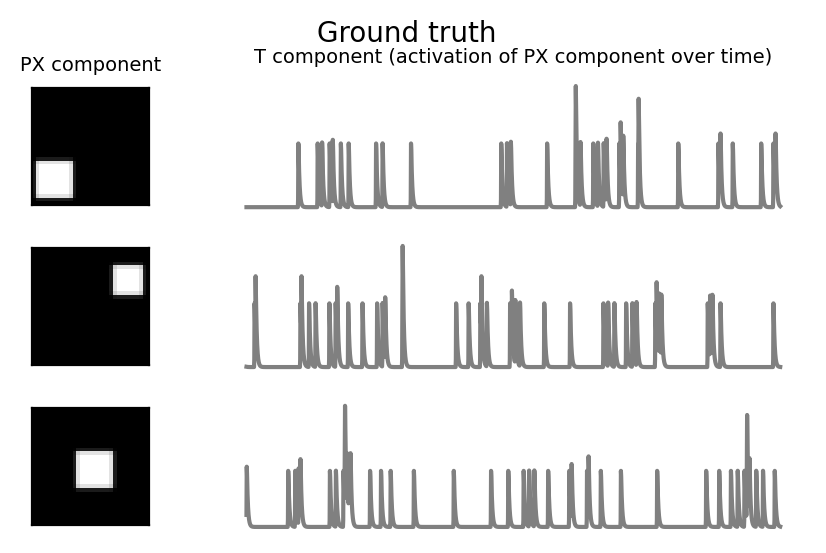

In [9]:
# plot of how true patches get activated over time
plot_roi_loading_time(truth_pxs, truth_ts, title='Ground truth')

In [10]:
if permute:
    spatial_permutation = np.random.permutation(32*32)
    
    movie_flat = movie.reshape((-1, 32*32))
    movie_flat_perm = movie_flat[:,spatial_permutation]
    movie_perm = movie_flat_perm.reshape((-1, 32, 32))
    movie = movie_perm
    
    # saving permuted activity matrix
    np.save(sim_path + '/movie_flat_perm.npy', movie_flat_perm)
    
else:
    
    movie_flat = movie.reshape((-1, 32*32))
    np.save(sim_path + '/movie_flat.npy', movie_flat)


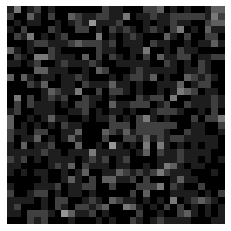

In [11]:
# gif of the 'movie'
animate_movie(movie, sim_path)

# KMeans clustering of simulated data

In [12]:
data = movie.reshape((-1, params.xy_px**2)).T

In [13]:
model = KMeans(n_clusters)
model.fit(data)
clu = model.predict(data)

/home/jure/miniconda3/envs/patch-nmf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


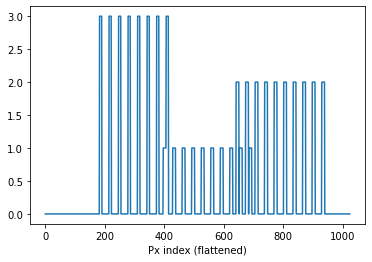

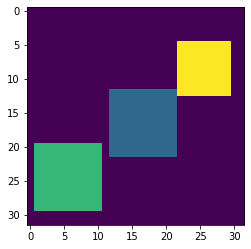

In [14]:
plt.plot(clu)
plt.xlabel('Px index (flattened)')
plt.show()
plt.imshow(clu.reshape(32,32))
plt.show()

# TSlearn Kmeans with dynamic time warping

In [15]:
from tqdm.auto import tqdm

/home/jure/miniconda3/envs/patch-nmf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def dtw_similarity(data, centroid):

    return [dtw.distance_fast(data[i], centroid, window=3) for i in range(data.shape[0])]

In [17]:
import numpy as np
from dtaidistance import dtw

class KMeans:
    def __init__(self, k, similarity_func, epsilon=10**-5, max_iterations=100):
        """
        K-means clustering with customizable similarity function.

        Args:
            k (int): Number of clusters.
            similarity_func (function): Similarity function that takes two data points as input and returns a similarity score.
            max_iterations (int): Maximum number of iterations for the algorithm.

        """
        self.k = k
        self.similarity_func = similarity_func
        self.max_iterations = max_iterations
        self.labels = None
        self.centroids = None
        self.epsilon = epsilon

    def fit(self, data):
        """
        Fit the K-means model to the data.

        Args:
            data (ndarray): Input data of shape (n_samples, n_features).

        """
        # Initialize centroids randomly
        self.centroids = data[np.random.choice(data.shape[0], self.k, replace=False)]

        for i in tqdm(range(self.max_iterations)):
            print("Iteration", (i+1), ':')

            print("Assign each point to the nearest centroid...")

            # Assign each point to the nearest centroid
            self.labels = np.argmin([self.similarity_func(data, centroid) for centroid in self.centroids], axis=0)

            print("Update the centroids...")
            # Update the centroids
            new_centroids = np.array([data[self.labels == i].mean(axis=0) if np.sum(self.labels == i) > 0 else centroid for i, centroid in enumerate(self.centroids)])

            #This block is made to know if we shoud keep or stop iterating to find new centeroids
            stop = True

            #If one of the centroids is diffrent from the old (do not stop)
            for i in range(self.centroids.shape[0]):

              dist = dtw.distance_fast(new_centroids[i], self.centroids[i])

              print(dist)

              if dist > self.epsilon:

                stop = False

                self.centroids = new_centroids

                break

            # If all of them are the same stop the process
            if stop:

              break

    def predict(self, data):
        """
        Predict the cluster labels for the given data.

        Args:
            data (ndarray): Input data of shape (n_samples, n_features).

        Returns:
            labels (ndarray): Cluster labels for each data point.

        """

        print("Predicting...")

        labels = np.argmin([self.similarity_func(data, centroid) for centroid in self.centroids], axis=0)
        return labels

In [18]:
kmeans = KMeans(k=4, similarity_func=dtw_similarity, epsilon=10**-6, max_iterations= 50)
kmeans.fit(data)

clu = kmeans.predict(data)
print("Cluster labels:", clu)
print("Centroids:", kmeans.centroids)

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1 :
Assign each point to the nearest centroid...


  2%|▏         | 1/50 [00:00<00:12,  3.78it/s]

Update the centroids...
41.50511258422302
Iteration 2 :
Assign each point to the nearest centroid...


  4%|▍         | 2/50 [00:00<00:13,  3.61it/s]

Update the centroids...
3.2081168695118807
Iteration 3 :
Assign each point to the nearest centroid...


  6%|▌         | 3/50 [00:00<00:14,  3.15it/s]

Update the centroids...
0.0
0.0
2.2568818660478893
Iteration 4 :
Assign each point to the nearest centroid...


  8%|▊         | 4/50 [00:01<00:13,  3.45it/s]

Update the centroids...
0.10524643693727434
Iteration 5 :
Assign each point to the nearest centroid...


 10%|█         | 5/50 [00:01<00:12,  3.48it/s]

Update the centroids...
2.4837428210408237
Iteration 6 :
Assign each point to the nearest centroid...


 12%|█▏        | 6/50 [00:01<00:12,  3.53it/s]

Update the centroids...
2.2368738751892345
Iteration 7 :
Assign each point to the nearest centroid...


 14%|█▍        | 7/50 [00:01<00:11,  3.65it/s]

Update the centroids...
0.4227240876366802
Iteration 8 :
Assign each point to the nearest centroid...


 16%|█▌        | 8/50 [00:02<00:11,  3.78it/s]

Update the centroids...
0.6954084042335241
Iteration 9 :
Assign each point to the nearest centroid...


 18%|█▊        | 9/50 [00:02<00:10,  3.79it/s]

Update the centroids...
5.626291422941352
Iteration 10 :
Assign each point to the nearest centroid...


 20%|██        | 10/50 [00:02<00:10,  3.75it/s]

Update the centroids...
5.780673496773989
Iteration 11 :
Assign each point to the nearest centroid...


 22%|██▏       | 11/50 [00:03<00:10,  3.68it/s]

Update the centroids...
0.9144718251304899
Iteration 12 :
Assign each point to the nearest centroid...


 22%|██▏       | 11/50 [00:03<00:12,  3.23it/s]

Update the centroids...
0.0
0.0
0.0
0.0
Predicting...


Cluster labels: [0 0 0 ... 0 0 0]
Centroids: [[0.95310344 0.95867788 0.97545789 ... 0.96105018 0.98067116 0.99637786]
 [1.49743488 3.77335921 3.55564899 ... 1.09503289 1.00949652 1.10554103]
 [0.93534645 1.06162429 0.87139648 ... 1.03838509 1.00555706 1.06692964]
 [1.00000681 1.00001788 1.01001561 ... 1.06014604 0.95684389 0.81734013]]


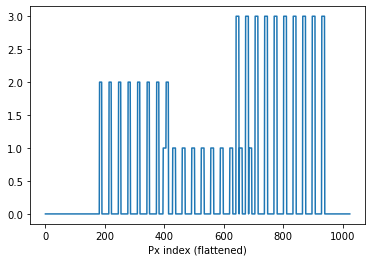

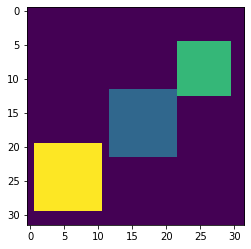

In [19]:
plt.plot(clu)
plt.xlabel('Px index (flattened)')
plt.show()
plt.imshow(clu.reshape(32,32))
plt.show()

In [20]:
organized_data = data[np.argsort(clu), :]

Text(0.5, 0, 'time')

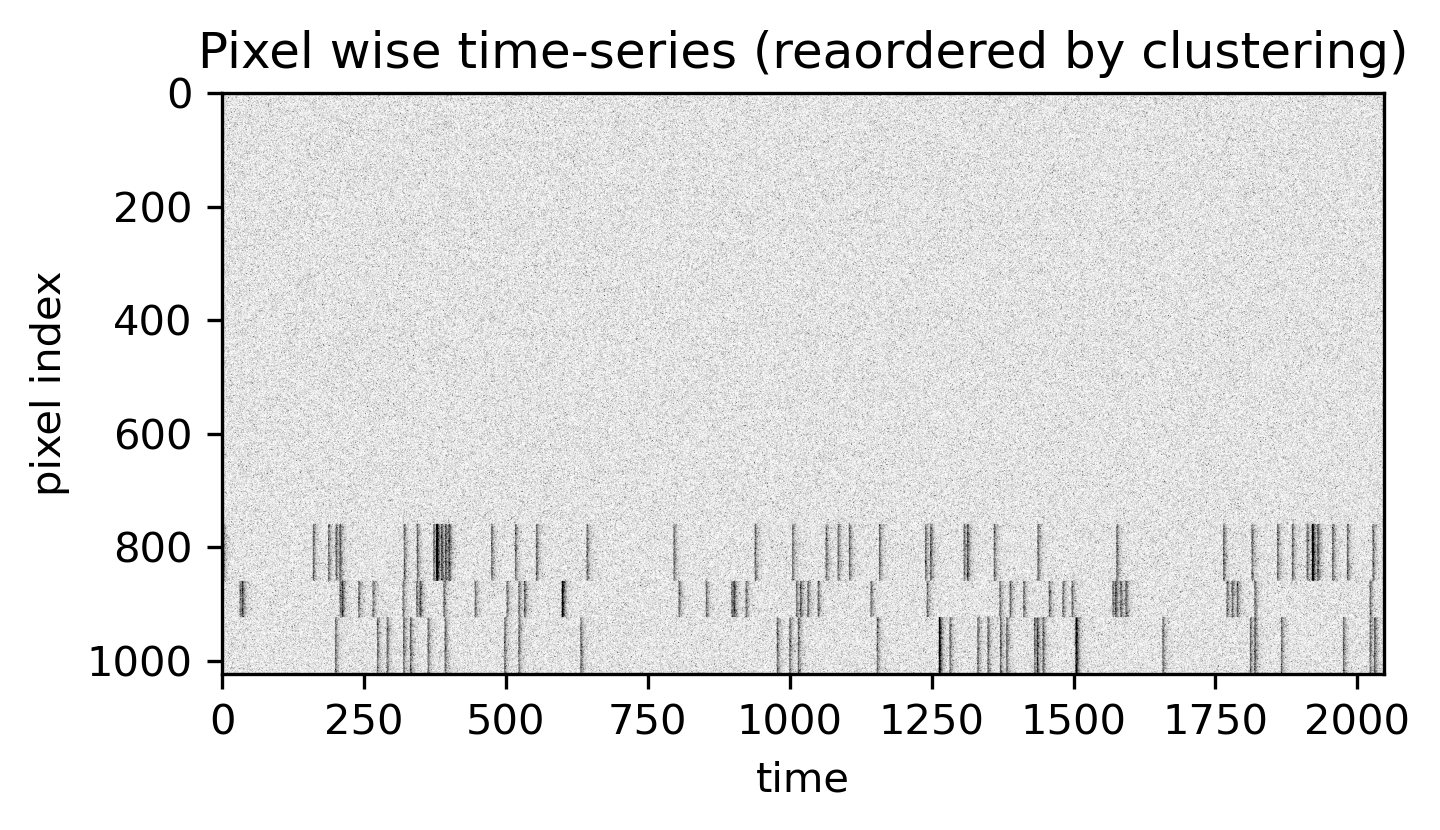

In [21]:
plt.figure(figsize=(5,10), dpi=300)
plt.imshow(organized_data,cmap='Greys', vmin=0, vmax=5)
plt.title('Pixel wise time-series (reaordered by clustering)')
plt.ylabel('pixel index')
plt.xlabel('time')